<a href="https://colab.research.google.com/github/Bhargavi1504/hospital_readmit_regression_notebook/blob/main/hospital.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
#data creation
import numpy as np
import pandas as pd
np.random.seed(42)
n=800
d=pd.DataFrame({
    'patient_id' : [f'{i:04d}' for i in range(n)],
    'Age' : np.random.randint(30,70,n),
    'Gender' : np.random.choice(['male','female','other'],n),
    'prior_visits' : np.random.poisson(2,n),
    'diagnosis_code' : np.random.choice([f'D{np.random.randint(10,99)}' for _ in range(200)],n),
    'has_chronic_condition': np.random.choice([0,1],n),
    'medication_count': np.random.randint(1,10,n),
    'insurance_type': np.random.choice(['private','govt','uninsured'],p=[0.6,0.35,0.05],size=n),
    'past_hb1ac-level': np.random.normal(6.5,1.5,n),
    'discharge_disposition' : np.random.choice(['home','rehab','Nursing home','deceased'],n),
    'admission_year': np.random.choice(['2021','2022','2023','2024','2025'],n),
    'length_of_stay': np.random.randint(4,15,n)

})

#injecting missing and outliers
#missing
d.loc[d.sample(frac=0.1).index,'Age']=np.nan
d.loc[d.sample(frac=0.2).index,'past_hb1ac-level']= np.nan
#outliers
d.loc[d.sample(frac=0.02).index,'prior_visits']=50
d.loc[d.sample(frac=0.1).index,'Age']= 82

#injecting correlation in target
lengthofstay=(
    (d['Age']*0.1)+
    (d['prior_visits']*0.5) +
    (d['has_chronic_condition']*5) +
    (d['medication_count']*0.8)
)

# Fill any NaNs from the calculation result before casting
lengthofstay= lengthofstay.fillna(1).astype(int)
d['length_of_stay']=np.clip(lengthofstay,1,None)

#adding noise
noise=np.random.rand(n)<0.05
d.loc[noise,'length_of_stay']=1


  patient_id   Age  Gender  prior_visits diagnosis_code  \
0       0000  82.0  female             3            D81   
1       0001  58.0    male             2            D75   
2       0002  44.0    male             1            D86   
3       0003  37.0  female             4            D82   
4       0004  50.0  female             1            D65   

   has_chronic_condition  medication_count insurance_type  past_hb1ac-level  \
0                      1                 9           govt          7.278593   
1                      1                 1        private          5.033788   
2                      0                 8        private          7.319193   
3                      1                 8           govt          5.309755   
4                      1                 6           govt          9.530539   

  discharge_disposition admission_year  length_of_stay  
0              deceased           2023              21  
1                 rehab           2025              12  

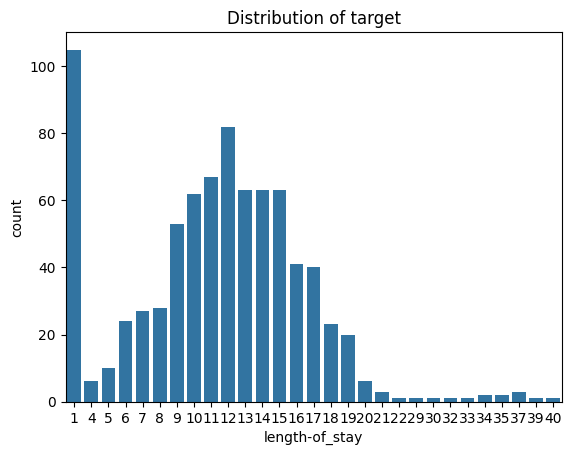

length_of_stay
1     105
12     82
11     67
13     63
15     63
14     63
10     62
9      53
16     41
17     40
8      28
7      27
6      24
18     23
19     20
5      10
4       6
20      6
21      3
37      3
34      2
35      2
39      1
22      1
40      1
32      1
33      1
30      1
29      1
Name: count, dtype: int64


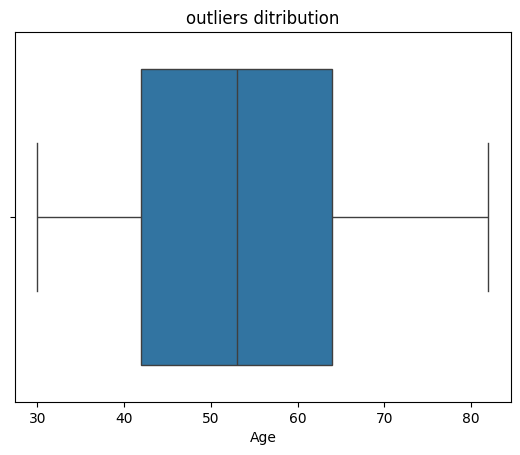

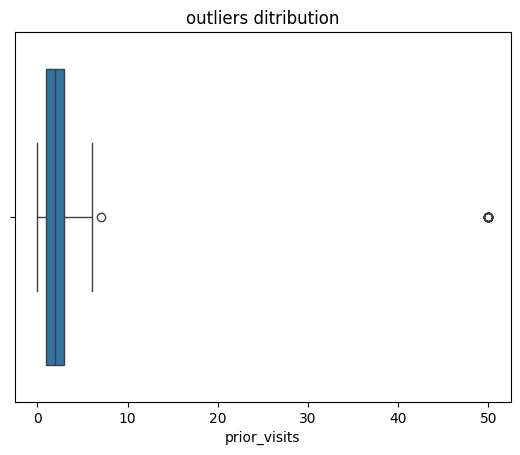

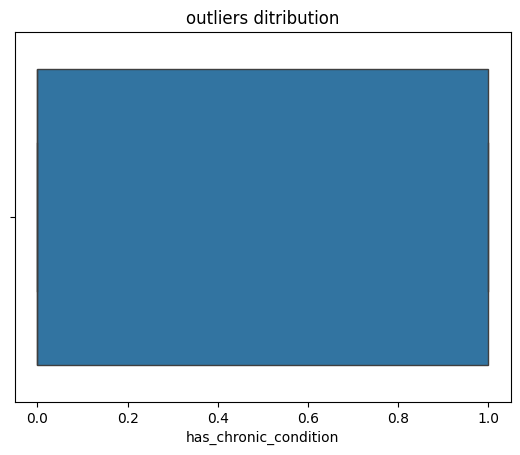

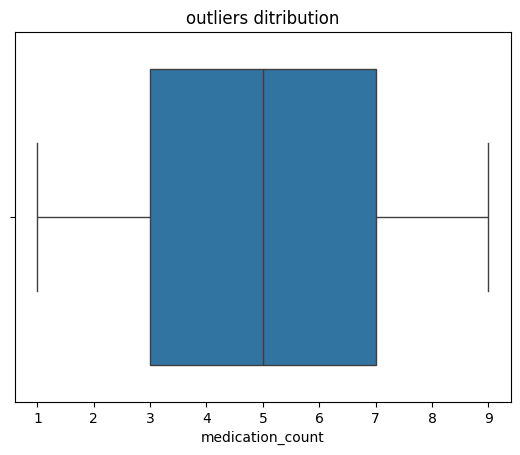

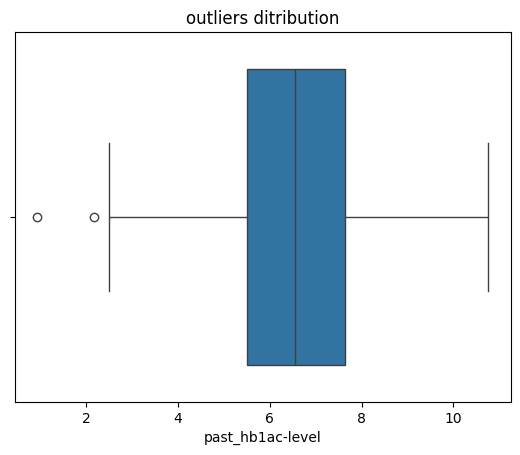

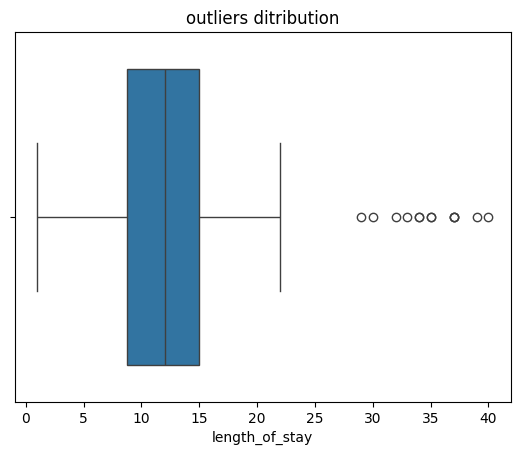

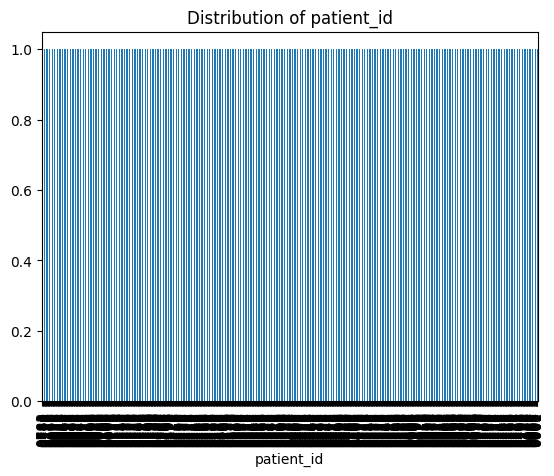

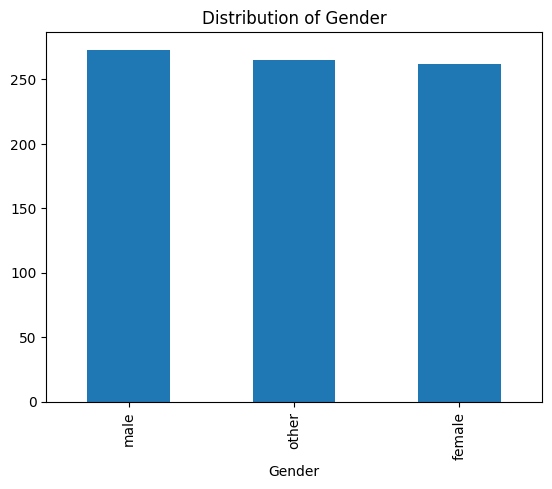

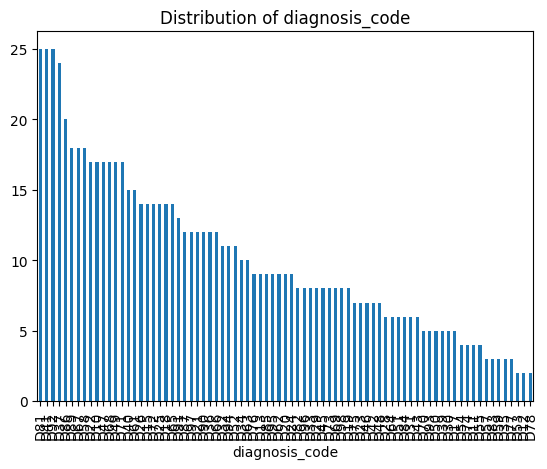

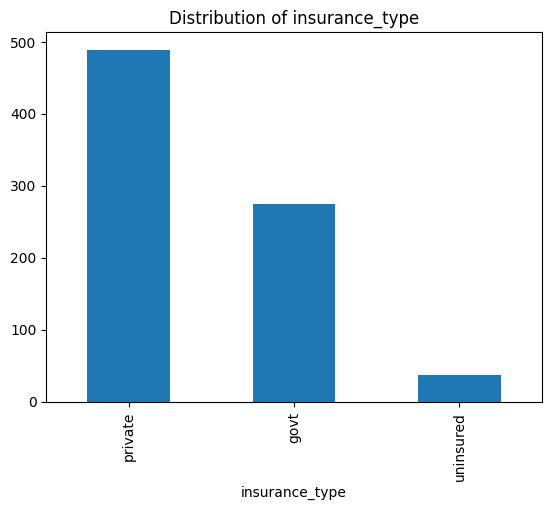

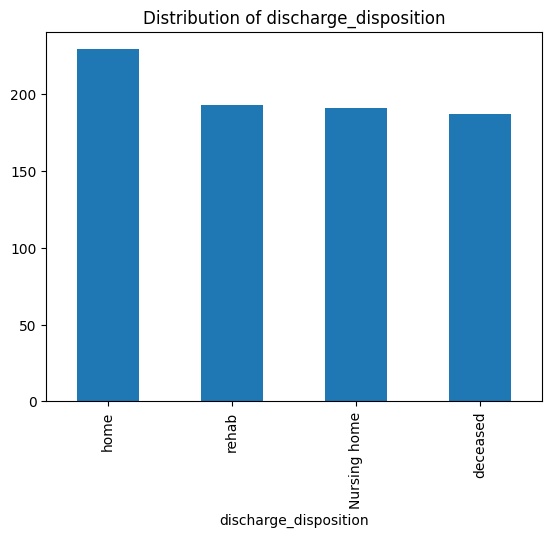

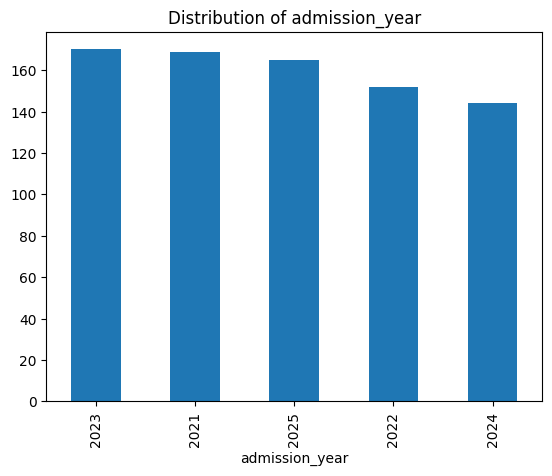

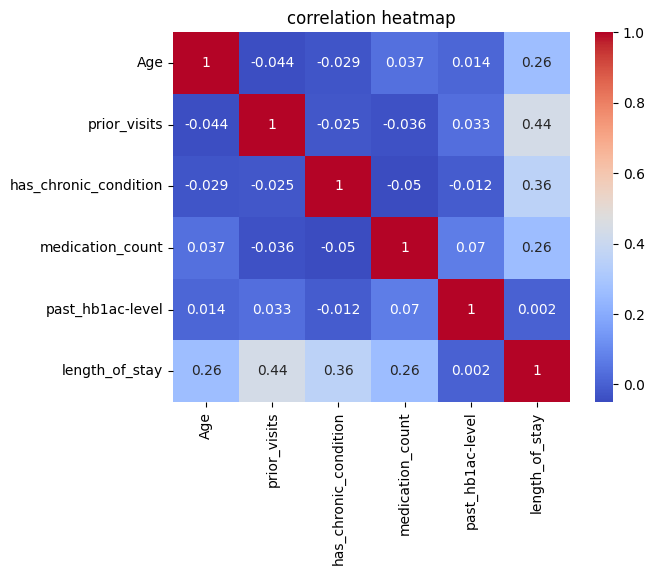

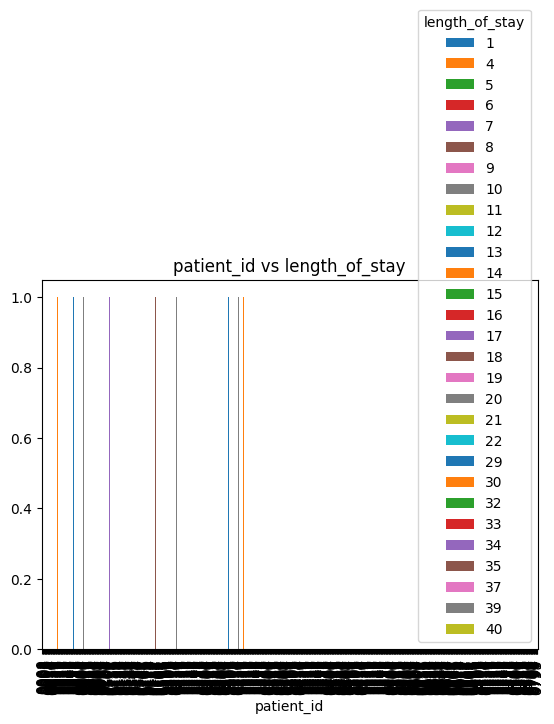

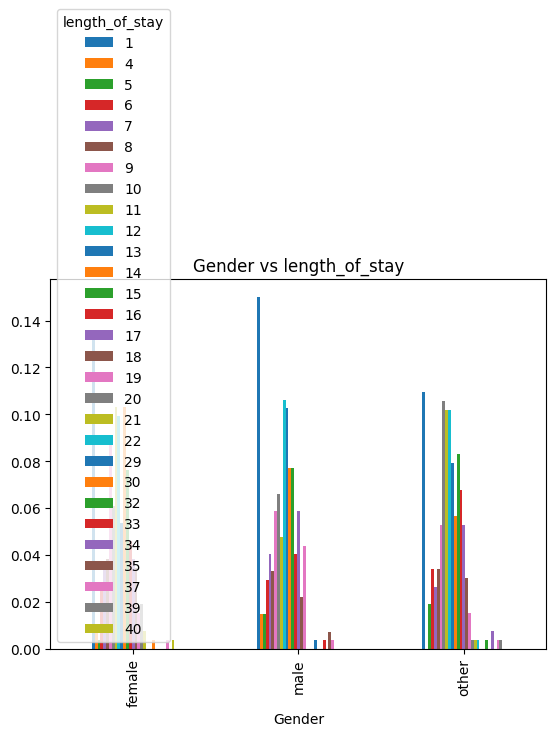

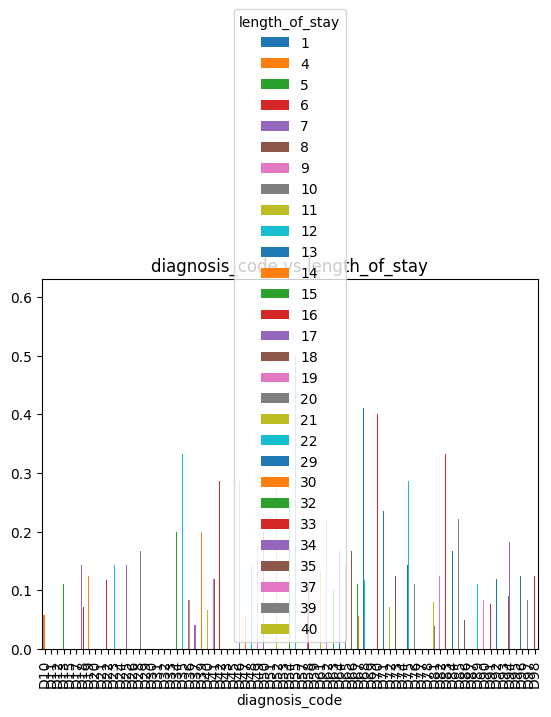

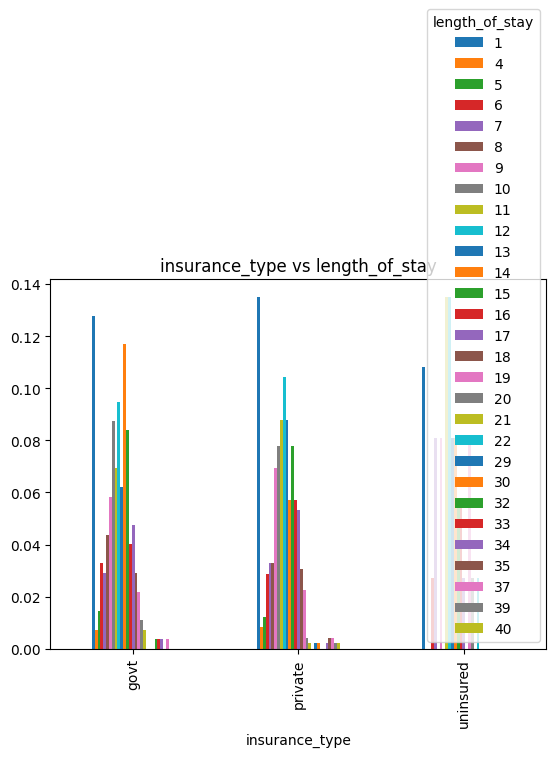

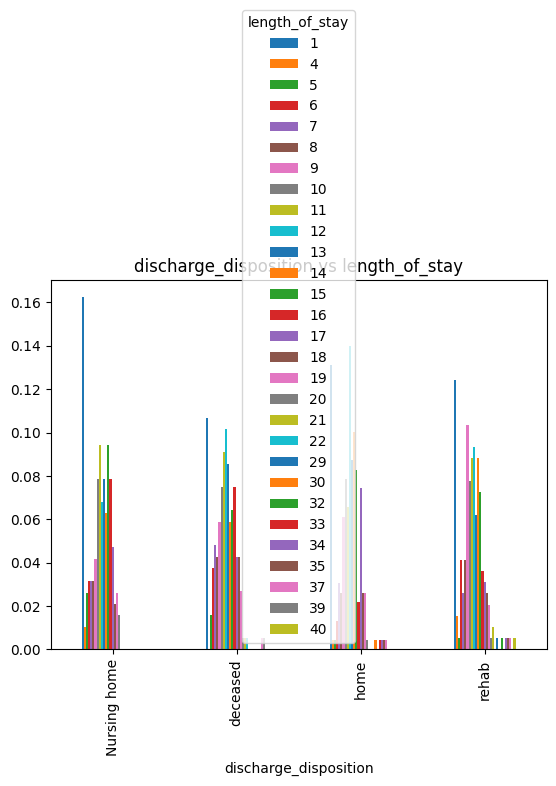

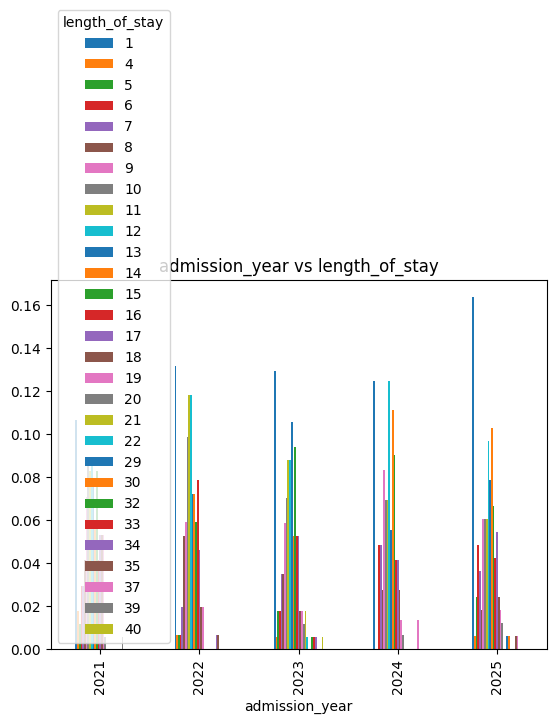

In [58]:
#data understanding
print(d.head())
print(d.info())
print(d.shape)

#summary stats
#print(d.describe())
d.select_dtypes(include=np.number).describe().T

#Cardinality
cat_c = d.select_dtypes(include='object').columns.tolist()
if 'patient_id' in cat_c:
  cat_c.remove('patient_id')
for i in cat_c:
  print(f'the {i} has the no. of unique features are {d[i].nunique()} and the values are {d[i].unique()}')

#missing values
missing=d.isnull().sum()
percentage=(missing/len(d))*100
print(pd.DataFrame({'the missing count':missing,'missing %' : percentage}))

#duplicates
print('the duplicate values are:',d.duplicated().sum())

#data types
print('the data types are:',d.dtypes)

#distribution of target variable
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='length_of_stay',data=d)
plt.title('Distribution of target')
plt.xlabel('length-of_stay')
plt.show()

#class imbalance in target
print(d['length_of_stay'].value_counts())

#outlier detection-numvalues
num_c=d.select_dtypes(include=['int64','float64']).columns.tolist()
for col in num_c:
  sns.boxplot(x=d[col],data=d)
  plt.title('outliers ditribution')
  plt.show()

#cat distribution
cat_c=d.select_dtypes(include='object').columns.tolist()
for c in cat_c:
  d[c].value_counts().plot(kind='bar',title=f'Distribution of {c}')
  plt.show()

#correlation
corr=d.corr(numeric_only=True)
sns.heatmap(corr,annot=True,cmap='coolwarm')
plt.title('correlation heatmap')
plt.show()

#crosstab for cat vs target
for cr in cat_c:
  ct=pd.crosstab(d[cr],d['length_of_stay'],normalize='index')
  ct.plot(kind='bar',title = f'{cr} vs length_of_stay')
  plt.show()



In [59]:
print(d.skew(numeric_only=True))
print(d.kurtosis(numeric_only=True))

Age                      0.329192
prior_visits             6.430149
has_chronic_condition    0.065157
medication_count        -0.007558
past_hb1ac-level        -0.081396
length_of_stay           0.585092
dtype: float64
Age                      -0.644630
prior_visits             41.350164
has_chronic_condition    -2.000763
medication_count         -1.238064
past_hb1ac-level         -0.043574
length_of_stay            3.126424
dtype: float64


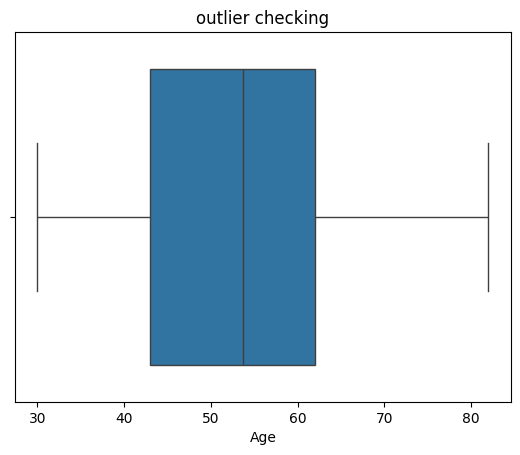

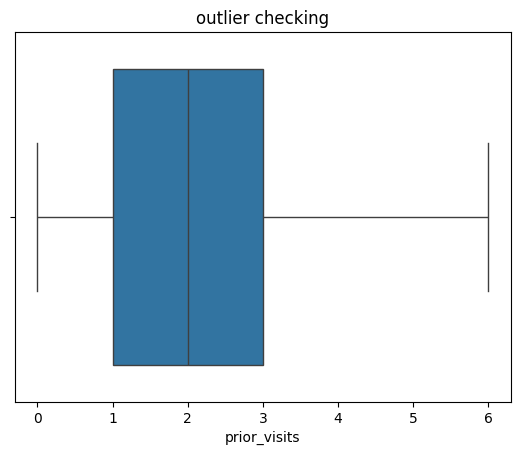

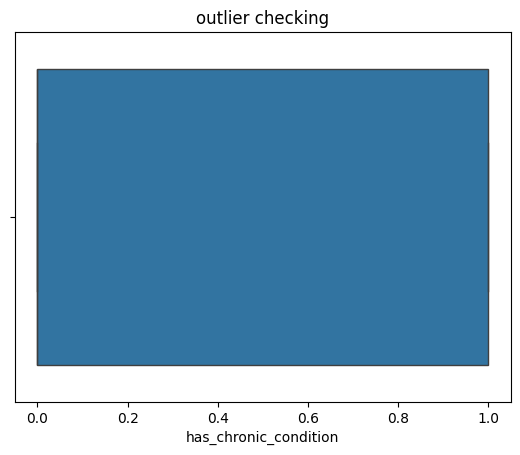

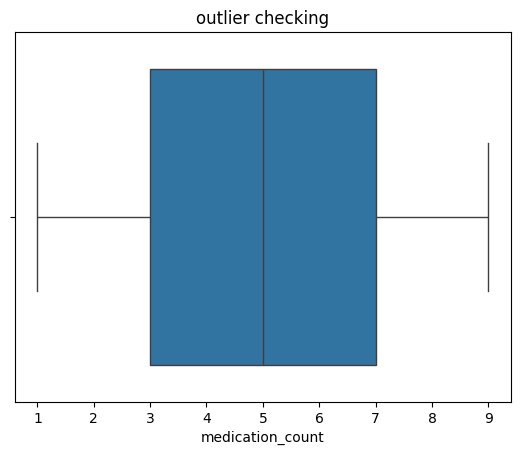

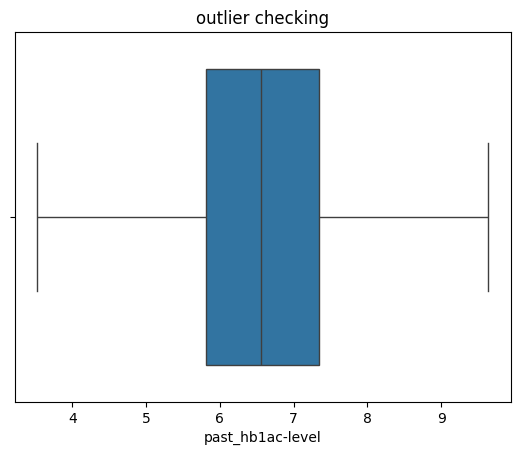

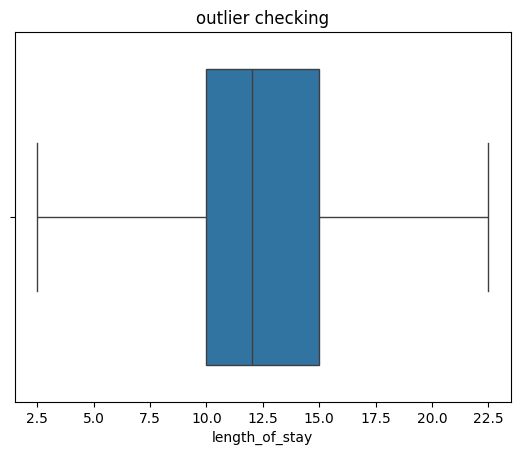

In [60]:
#data cleaning

#treating noise
# Step 1: Find all with LOS = 1
noise_rows=d[d['length_of_stay']==1]

# Step 2: Reduce 75% of them to more realistic values
to_fix= noise_rows.sample(frac=0.75,random_state=42)

# Step 3: Recalculate LOS for those
estimated_los=(
    (to_fix['Age'].fillna(60) * 0.1)+
    (to_fix['prior_visits'] * 0.5) +
    (to_fix['has_chronic_condition'] * 5) +
    (to_fix['medication_count'] * 0.8)
).astype(int).clip(lower=1)

# Step 4: Replace those entries
d.loc[to_fix.index, 'length_of_stay'] = estimated_los

#handle missing values
d['Age']=d['Age'].fillna(d['Age'].mean())
d['past_hb1ac-level']=d['past_hb1ac-level'].fillna(d['past_hb1ac-level'].median())

#handle outliers
def capping_outliers(d,i):
  Q1=d[i].quantile(0.25)
  Q3=d[i].quantile(0.75)
  IQR=Q3-Q1
  lower_b=Q1-1.5*IQR
  upper_b=Q3+1.5*IQR
  d[i]=np.where(d[i]<lower_b,lower_b,np.where(d[i]>upper_b,upper_b,d[i]))
  return d

#applying to all
out_cols=['length_of_stay','prior_visits','past_hb1ac-level']
for i in out_cols:
  d=capping_outliers(d,i)

#verifying
num_c=d.select_dtypes(include=['int64','float64']).columns.tolist()
for c in num_c:
  sns.boxplot(x=d[c],data=d)
  plt.title('outlier checking')
  plt.show()







In [61]:
print(d.isnull().sum())
print(d.describe())

patient_id               0
Age                      0
Gender                   0
prior_visits             0
diagnosis_code           0
has_chronic_condition    0
medication_count         0
insurance_type           0
past_hb1ac-level         0
discharge_disposition    0
admission_year           0
length_of_stay           0
dtype: int64
              Age  prior_visits  has_chronic_condition  medication_count  \
count  800.000000     800.00000             800.000000        800.000000   
mean    53.682561       2.11125               0.483750          4.912500   
std     14.072627       1.50805               0.500048          2.583251   
min     30.000000       0.00000               0.000000          1.000000   
25%     43.000000       1.00000               0.000000          3.000000   
50%     53.682561       2.00000               0.000000          5.000000   
75%     62.000000       3.00000               1.000000          7.000000   
max     82.000000       6.00000               1.000000 

In [62]:
#fix incorrect data
d['admission_year']=d['admission_year'].astype(int)
#rename cols
d.rename(columns={'past_hb1ac-level':'past_hb1ac_level'},inplace=True)
#handle duplicates
d.drop_duplicates()
#encode cat cols
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
d['discharge_disposition']=le.fit_transform(d['discharge_disposition'])
d['insurance_type']=le.fit_transform(d['insurance_type'])
d['diagnosis_code']=le.fit_transform(d['diagnosis_code'])
d['Gender']=le.fit_transform(d['Gender'])

d.drop(columns=['patient_id'],inplace=True)
#class imbalance check in target
print(d['length_of_stay'].value_counts())

length_of_stay
12.0    90
11.0    79
13.0    71
14.0    71
15.0    67
10.0    65
9.0     58
17.0    43
16.0    42
8.0     35
7.0     34
18.0    29
2.5     26
6.0     25
19.0    22
22.5    15
5.0     10
20.0     7
4.0      7
21.0     3
22.0     1
Name: count, dtype: int64


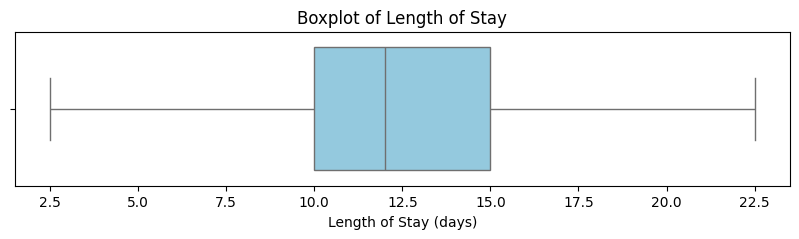

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
sns.boxplot(x=d['length_of_stay'], color='skyblue')
plt.title("Boxplot of Length of Stay")
plt.xlabel("Length of Stay (days)")
plt.show()


In [64]:
print(d.isnull().sum())
print(d.columns)

Age                      0
Gender                   0
prior_visits             0
diagnosis_code           0
has_chronic_condition    0
medication_count         0
insurance_type           0
past_hb1ac_level         0
discharge_disposition    0
admission_year           0
length_of_stay           0
dtype: int64
Index(['Age', 'Gender', 'prior_visits', 'diagnosis_code',
       'has_chronic_condition', 'medication_count', 'insurance_type',
       'past_hb1ac_level', 'discharge_disposition', 'admission_year',
       'length_of_stay'],
      dtype='object')


In [65]:
#feature engineering
#binning
d['Age_group']=pd.cut(d['Age'],bins=[0,40,60,100],labels=['young','middle','senior'])
d['Age_group']=le.fit_transform(d['Age_group'])

#interaction features
d['meds_chronic_interaction']=d['medication_count']*d['has_chronic_condition']

# Aggregation by diagnosis_code: average length of stay
agg_diagnosis=d.groupby('diagnosis_code')['length_of_stay'].agg(['mean','median']).reset_index()
agg_diagnosis.columns=['diagnosis_code','diag_loas_mean','diag_los_median']

#encode target variable
#d['length_of_stay']=le.fit_transform(d['length_of_stay'])

# Year difference from most recent year
d['admission_gap']=2025-d['admission_year']

# HbA1c risk level (binarized from past_hb1ac_level)
d['high_risk_hb1ac']= (d['past_hb1ac_level'] > 7.0).astype(int)


# Polynomial feature (age² scaled down)
d['Age_squared_scaled'] = (d['Age'] ** 2)/100

#print('the cat cols are ',cat_c)
#d['diagnosis_code']=d['diagnosis_code'].str.extract(r'(\d+)').astype(int)


# Frequency or Count Encoding
freq=d['diagnosis_code'].value_counts()
d['diagnosis_code']=d['diagnosis_code'].map(freq)

#Feature Transformation (log/sqrt)
d['log_prior_visits']=np.log1p(d['prior_visits'])
d['sqrt_length_of_stay']= np.sqrt(d['length_of_stay'])


In [66]:
 #5-Feature selection
 #5.1 – Correlation-Based Filtering (for numeric features)

corr_mat=d.corr().abs()
upper=corr_mat.where(np.triu(np.ones(corr_mat.shape),k=1).astype(bool))
to_drop=[col for col in upper.columns if any(upper[col]>0.85)]
d.drop(columns=to_drop,inplace=True)
print('the dropped columns due to high correlation are ',to_drop)

# 5.2 – Low Variance Filter
from sklearn.feature_selection import VarianceThreshold
selector=VarianceThreshold(threshold=0.01)
d_vari=selector.fit_transform(d)
selected_cols=d.columns[selector.get_support()]
d=d[selected_cols]
print('selected due to low variance:',selected_cols)





the dropped columns due to high correlation are  ['admission_gap', 'Age_squared_scaled', 'log_prior_visits', 'sqrt_length_of_stay']
selected due to low variance: Index(['Age', 'Gender', 'prior_visits', 'diagnosis_code',
       'has_chronic_condition', 'medication_count', 'insurance_type',
       'past_hb1ac_level', 'discharge_disposition', 'admission_year',
       'length_of_stay', 'Age_group', 'meds_chronic_interaction',
       'high_risk_hb1ac'],
      dtype='object')


In [67]:
#splitting
x=d.drop('length_of_stay',axis=1)
y=d['length_of_stay']

🎯 Selected Features (SelectKBest): ['Age', 'Gender', 'prior_visits', 'diagnosis_code', 'has_chronic_condition', 'medication_count', 'insurance_type', 'past_hb1ac_level', 'discharge_disposition', 'admission_year', 'Age_group', 'meds_chronic_interaction', 'high_risk_hb1ac']
🎯 RFE Selected Features: ['Age', 'Gender', 'prior_visits', 'diagnosis_code', 'has_chronic_condition', 'medication_count', 'insurance_type', 'past_hb1ac_level', 'discharge_disposition', 'admission_year', 'Age_group', 'meds_chronic_interaction', 'high_risk_hb1ac']


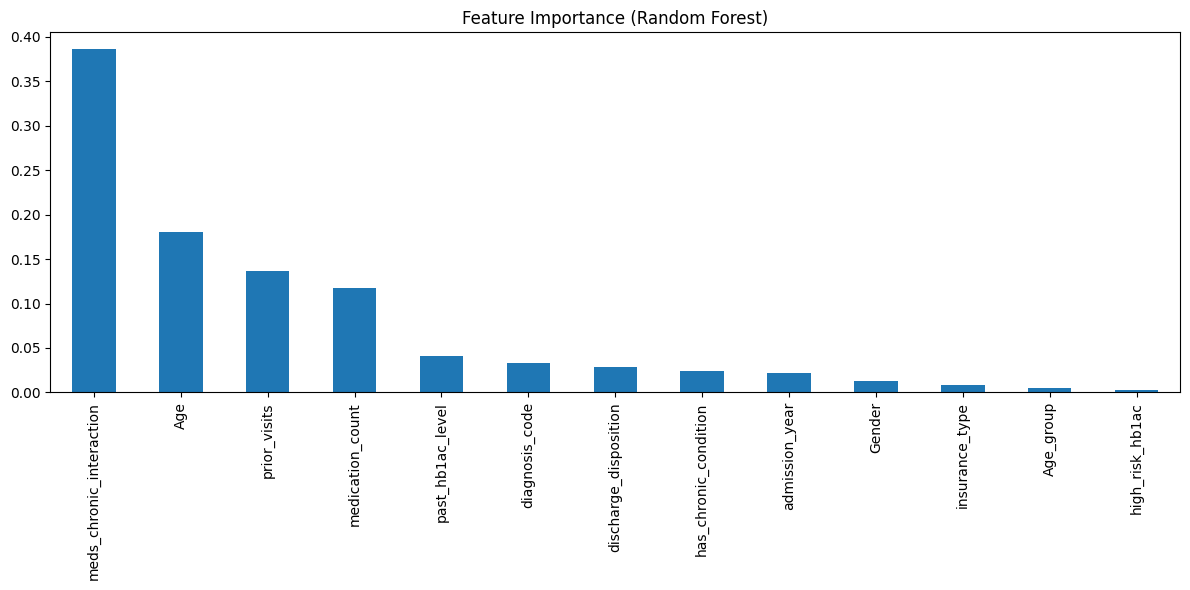

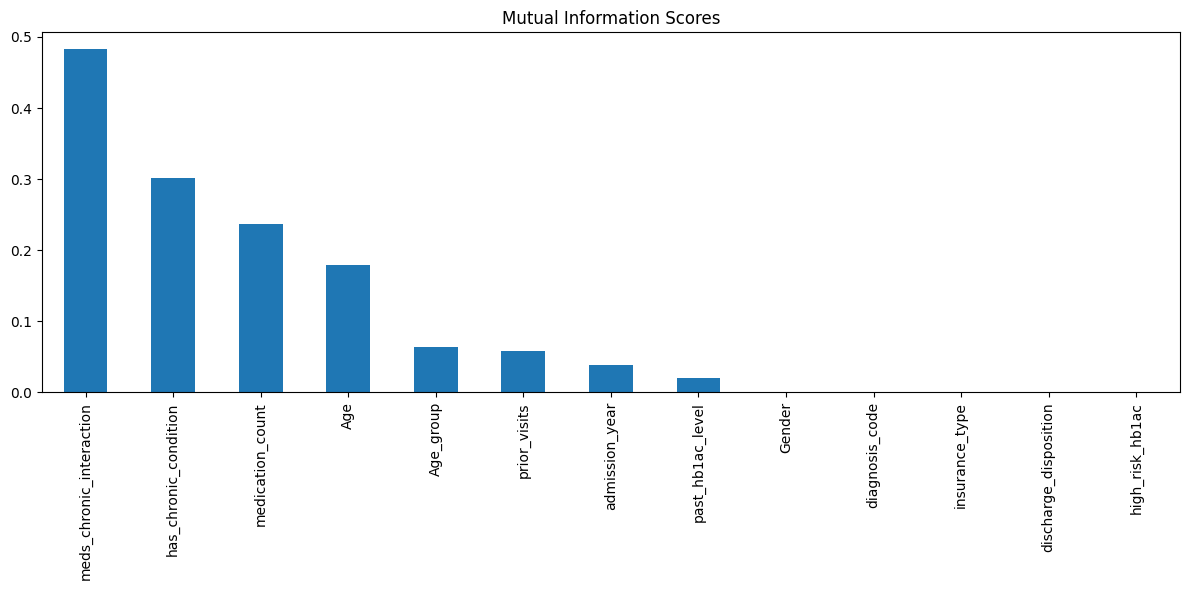

✅ Final selected feature shape: (800, 13)


In [68]:

from sklearn.feature_selection import SelectKBest, f_regression, RFE, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Only numerical columns (because all are numeric now)
num_cols = x.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Final preprocessing for regression
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),   # already handled, but for safety
    ('scaler', StandardScaler())
])

# Preprocessing step
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols)
])


x_processed = preprocessor.fit_transform(x)

# Step 5: Combine all feature names
all_feature_names = num_cols + list(cat_features)

# Step 6: Feature Selection - SelectKBest
selector = SelectKBest(score_func=f_regression, k=15)
X_kbest = selector.fit_transform(x_processed, y)
selected_features_kbest = [all_feature_names[i] for i, sel in enumerate(selector.get_support()) if sel]
print("🎯 Selected Features (SelectKBest):", selected_features_kbest)

# Step 7: Feature Selection - RFE
rfe_selector = RFE(estimator=RandomForestRegressor(), n_features_to_select=15)
x_rfe = rfe_selector.fit_transform(x_processed, y)
rfe_selected = [all_feature_names[i] for i, sel in enumerate(rfe_selector.get_support()) if sel]
print("🎯 RFE Selected Features:", rfe_selected)

# Step 8: Feature Importance (Random Forest)
model = RandomForestRegressor()
model.fit(x_processed, y)
feat_importances = pd.Series(model.feature_importances_, index=all_feature_names)
feat_importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), title='Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

# Step 9: Mutual Information
mi_scores = mutual_info_regression(x_processed, y)
mi_df = pd.Series(mi_scores, index=all_feature_names).sort_values(ascending=False)
mi_df.plot(kind='bar', figsize=(12, 6), title='Mutual Information Scores')
plt.tight_layout()
plt.show()

# Step 10: Final selected features (from SelectKBest, can change to RFE if preferred)
x_selected = X_kbest
x_selected_df = pd.DataFrame(x_selected, columns=selected_features_kbest)
print("✅ Final selected feature shape:", x_selected_df.shape)


In [69]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_processed,y,test_size=0.2,random_state=42)

In [70]:
# ✅ All required imports
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ✅ Base models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet Regression': ElasticNet(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regressor': SVR(),
    'KNN Regressor': KNeighborsRegressor()
}

# ✅ Try adding XGBoost
try:
    from xgboost import XGBRegressor
    models['XGBoost Regressor'] = XGBRegressor(random_state=42, verbosity=0)
except ImportError:
    print("⚠️ XGBoost not installed.")

# ✅ Evaluation
results = []
trained_models = {}

def evaluate_model(name, model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"📌 {name} — RMSE: {rmse:.4f}, R²: {r2:.4f}")
    return {'Model': name, 'RMSE': rmse, 'R2': r2}, model

# ✅ Train and collect results
for name, model in models.items():
    result, trained = evaluate_model(name, model, x_train, y_train, x_test, y_test)
    results.append(result)
    trained_models[name] = trained  # Save trained model

# ✅ Results DataFrame
results_df = pd.DataFrame(results).sort_values(by='R2', ascending=False)
display(results_df)



📌 Linear Regression — RMSE: 2.4193, R²: 0.6938
📌 Ridge Regression — RMSE: 2.4190, R²: 0.6938
📌 Lasso Regression — RMSE: 3.3988, R²: 0.3956
📌 ElasticNet Regression — RMSE: 3.0752, R²: 0.5052
📌 Decision Tree — RMSE: 2.8674, R²: 0.5699
📌 Random Forest — RMSE: 2.3671, R²: 0.7069
📌 Gradient Boosting — RMSE: 2.3784, R²: 0.7040
📌 Support Vector Regressor — RMSE: 2.5847, R²: 0.6505
📌 KNN Regressor — RMSE: 2.8735, R²: 0.5680
📌 XGBoost Regressor — RMSE: 2.5032, R²: 0.6722


,Model,RMSE,R2
5,Random Forest,2.367050,0.706868
6,Gradient Boosting,2.378435,0.704042
1,Ridge Regression,2.419041,0.693850
0,Linear Regression,2.419311,0.693782
9,XGBoost Regressor,2.503216,0.672173
7,Support Vector Regressor,2.584740,0.650472
4,Decision Tree,2.867381,0.569851
8,KNN Regressor,2.873478,0.568020
3,ElasticNet Regression,3.075201,0.505240
2,Lasso Regression,3.398809,0.395632


In [71]:
# ✅ Get best model name and object
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]
print(f"\n🏆 Best Model Based on R²: {best_model_name}")




🏆 Best Model Based on R²: Random Forest


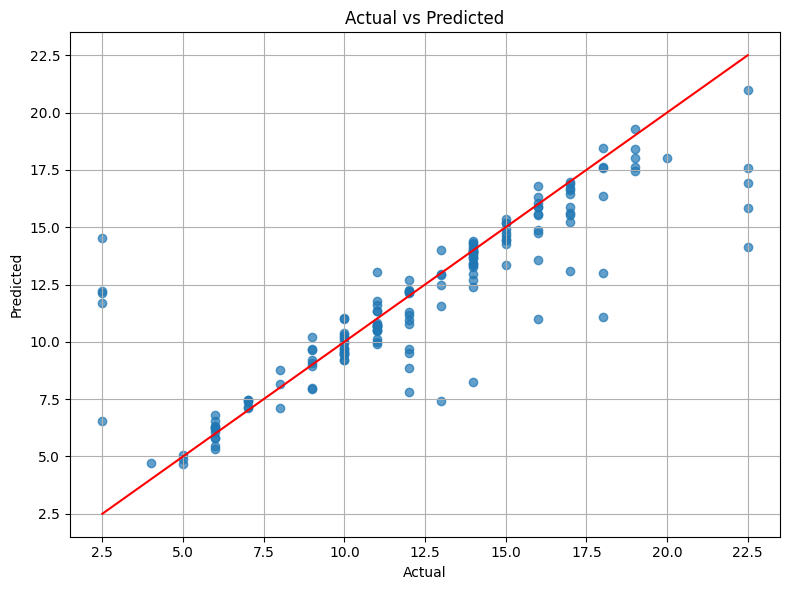

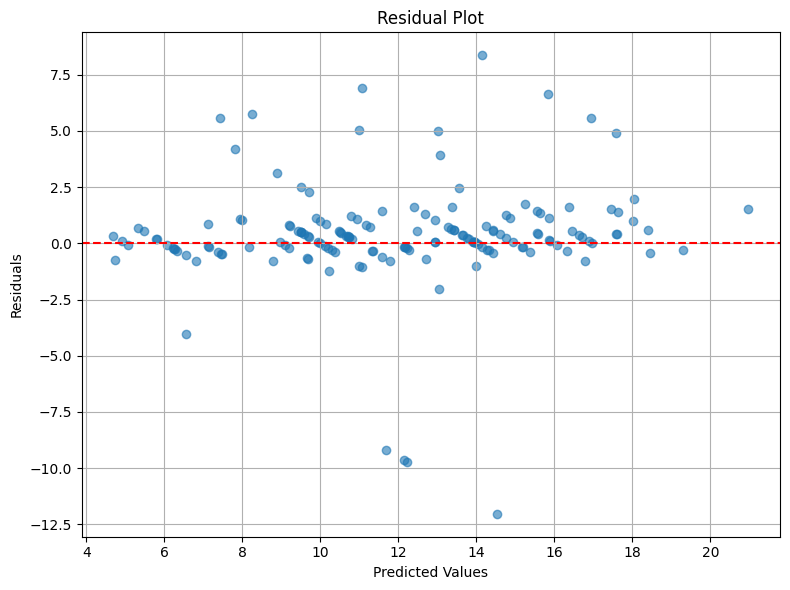

In [72]:
#4. Visualize Predictions vs Actual
y_pred = best_model.predict(x_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

#🔹 5. Residual Plot (Optional)
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.tight_layout()
plt.show()


In [73]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ✅ Define RMSE scorer (as negative, since sklearn minimizes)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# ✅ Define models
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge(alpha=1.0)),
    ('Lasso Regression', Lasso(alpha=0.01)),
    ('ElasticNet Regression', ElasticNet(alpha=0.01, l1_ratio=0.5)),
    ('Decision Tree', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('Support Vector Regressor', SVR()),
    ('KNN Regressor', KNeighborsRegressor())
]

# ✅ Cross-validation settings
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# ✅ Evaluate all models
results = []

for name, model in models:
    # R² Score
    r2_scores = cross_val_score(model, x_train, y_train, cv=cv, scoring='r2')

    # RMSE (Note: returns negative, so we take absolute value)
    rmse_scores = cross_val_score(model, x_train, y_train, cv=cv, scoring=rmse_scorer)

    results.append({
        'Model': name,
        'Mean R2': np.mean(r2_scores),
        'Std R2': np.std(r2_scores),
        'Mean RMSE': -np.mean(rmse_scores),
        'Std RMSE': np.std(rmse_scores)
    })

# ✅ Create results DataFrame
cv_results_df = pd.DataFrame(results)
cv_results_df = cv_results_df.sort_values(by='Mean R2', ascending=False)

# ✅ Display results
print("📊 Model Performance with 5-Fold Cross-Validation:")
display(cv_results_df)


📊 Model Performance with 5-Fold Cross-Validation:


,Model,Mean R2,Std R2,Mean RMSE,Std RMSE
2,Lasso Regression,0.676552,0.074159,2.290841,0.318255
3,ElasticNet Regression,0.676325,0.073594,2.291971,0.316267
1,Ridge Regression,0.676130,0.073522,2.292736,0.316286
0,Linear Regression,0.676072,0.073664,2.292880,0.316886
5,Random Forest,0.652583,0.048006,2.385513,0.217119
6,Gradient Boosting,0.649241,0.028039,2.403317,0.204414
7,Support Vector Regressor,0.638220,0.079424,2.431288,0.381149
8,KNN Regressor,0.545630,0.055013,2.736175,0.301820
4,Decision Tree,0.233415,0.041855,3.554118,0.275791


In [74]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grids
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    'XGBoost Regressor': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    'Ridge Regression': {
        'alpha': [0.1, 1.0, 10.0]
    },
    'Lasso Regression': {
        'alpha': [0.001, 0.01, 0.1]
    },
    'ElasticNet Regression': {
        'alpha': [0.001, 0.01],
        'l1_ratio': [0.2, 0.5, 0.8]
    }
}

# Check if best model has grid defined
if best_model_name in param_grids:
    print(f"\n🔍 Performing Grid Search for: {best_model_name}")

    grid = GridSearchCV(
        estimator=best_model,
        param_grid=param_grids[best_model_name],
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(x_train, y_train)

    best_model = grid.best_estimator_  # Updated best model
    print("\n✅ Best Hyperparameters:", grid.best_params_)

    # Evaluate on test set
    y_pred = best_model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"\n📌 Tuned {best_model_name} Results on Test Set:")
    print(f"  ✅ RMSE: {rmse:.4f}")
    print(f"  ✅ R² Score: {r2:.4f}")

else:
    print(f"⚠️ No hyperparameter grid defined for {best_model_name}. Skipping tuning.")



🔍 Performing Grid Search for: Random Forest
Fitting 5 folds for each of 12 candidates, totalling 60 fits

✅ Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

📌 Tuned Random Forest Results on Test Set:
  ✅ RMSE: 2.3950
  ✅ R² Score: 0.6999


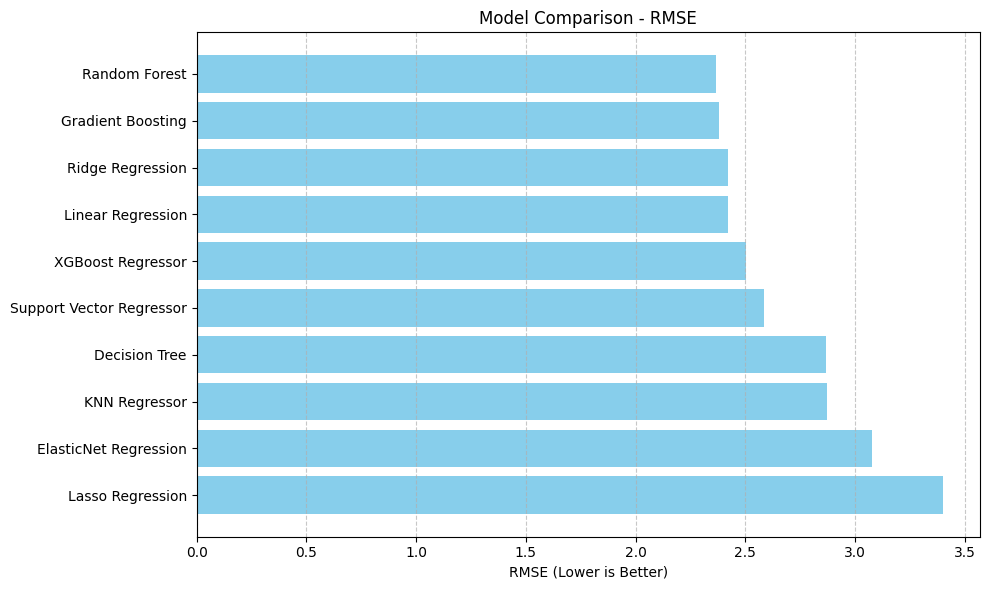

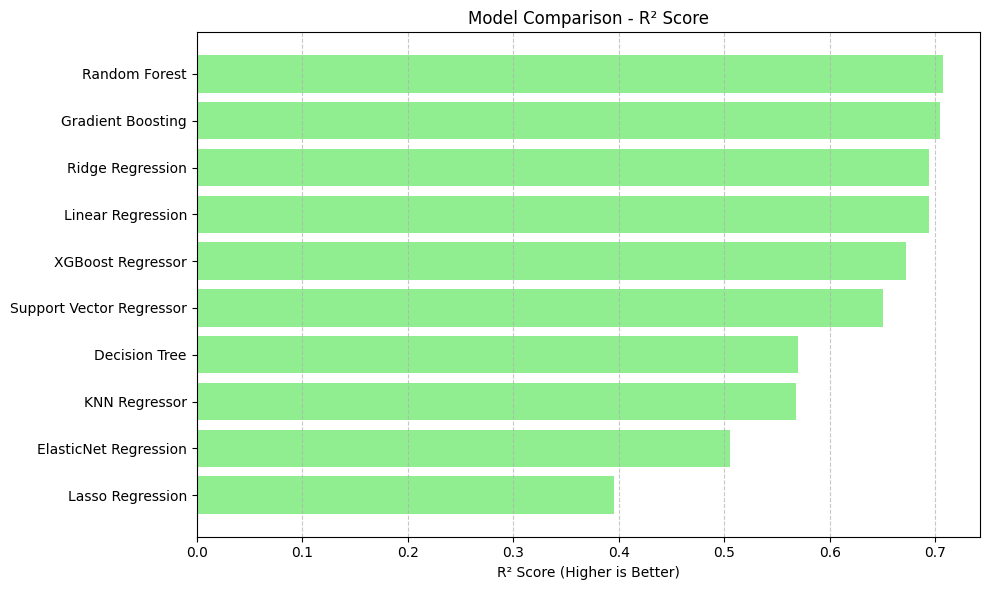

In [75]:
#model comparision
# ✅ Bar Plot - RMSE Comparison
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['RMSE'], color='skyblue')
plt.xlabel("RMSE (Lower is Better)")
plt.title("Model Comparison - RMSE")
plt.gca().invert_yaxis()  # Best model at top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ✅ Bar Plot - R² Score Comparison
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['R2'], color='lightgreen')
plt.xlabel("R² Score (Higher is Better)")
plt.title("Model Comparison - R² Score")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [85]:
import pandas as pd
import numpy as np

# 1️⃣ Define your new patient input (raw format)
new_patient = pd.DataFrame([{
    'Age': 52,
    'Gender': 'female',
    'prior_visits': 1,
    'diagnosis_code': 'D44',
    'has_chronic_condition': 1,
    'medication_count': 4,
    'insurance_type': 'govt',
    'past_hb1ac_level': 7.2,
    'discharge_disposition': 'home',
    'admission_year': 2024
}])

# 2️⃣ Manual label encoding for new input (as you did in training)
label_maps = {
    'Gender': {'male': 1, 'female': 0, 'other': 2},
    'insurance_type': {'private': 2, 'govt': 1, 'uninsured': 0},
    'discharge_disposition': {'home': 1, 'rehab': 2, 'Nursing home': 0, 'deceased': 3},
    # Use frequency encoding for diagnosis_code if needed — fallback to a mean
}

# Map label encoded fields
for col, mapping in label_maps.items():
    new_patient[col] = new_patient[col].map(mapping)

# Handle unseen diagnosis_code
if new_patient['diagnosis_code'].iloc[0] not in freq:
    new_patient['diagnosis_code'] = freq.mean()
else:
    new_patient['diagnosis_code'] = freq[new_patient['diagnosis_code'].iloc[0]]

# 3️⃣ Create derived features as in training
new_patient['Age_group'] = pd.cut(new_patient['Age'], bins=[0,40,60,100], labels=['young','middle','senior'])
new_patient['Age_group'] = new_patient['Age_group'].map({'young': 2, 'middle': 1, 'senior': 0})
new_patient['meds_chronic_interaction'] = new_patient['medication_count'] * new_patient['has_chronic_condition']
new_patient['high_risk_hb1ac'] = (new_patient['past_hb1ac_level'] > 7.0).astype(int)

# 4️⃣ Ensure all selected features are present and in order
final_input = new_patient[selected_features_kbest]

# 5️⃣ Apply preprocessing and prediction
final_input_processed = preprocessor.transform(final_input)
predicted_los = best_model.predict(final_input_processed)[0]

print(f"🧮 Predicted Length of Stay: {predicted_los:.2f} days")


🧮 Predicted Length of Stay: 13.72 days


You should not apply OneHotEncoder again — that’s meant for raw string categories
✅ Instead, treat them as numeric features in your ColumnTransformer